<a href="https://colab.research.google.com/github/Anshu00027/SAE-for-PINNs/blob/main/SAE-for-Taylor-Green-Vortex-PINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#  Redefine Model Architecture
class TGV(nn.Module):
    def __init__(self, layers):
        super().__init__()
        net = []
        for i in range(len(layers) - 2):
            net.append(nn.Linear(layers[i], layers[i + 1]))
            net.append(nn.SiLU())
        net.append(nn.Linear(layers[-2], layers[-1]))
        self.net = nn.Sequential(*net)

    def forward(self, x):
        return self.net(x)

# Step 4: Initialize and Load Weights

model = TGV([3, 15, 15, 15, 3])  # same architecture used when training
load_path = "/content/drive/MyDrive/Colab Notebooks/TGV(SAE)/saved_models/TGV_PSOAdam_weights.pth"

model.load_state_dict(torch.load(load_path))
model.eval()  # important: set model to evaluation mode

print("Model successfully loaded and ready for inference!")



Model successfully loaded and ready for inference!


In [8]:
rho = 4.0
nu = 1.0
n_points = 15
x_vals = np.linspace(0, np.pi, n_points)
y_vals = np.linspace(0, np.pi, n_points)
t_vals = np.linspace(0, 1, n_points)

X_grid, Y_grid, T_grid = np.meshgrid(x_vals, y_vals, t_vals, indexing="ij")

x_flat = X_grid.flatten()
y_flat = Y_grid.flatten()
t_flat = T_grid.flatten()

# Exactsolution

f_np = np.exp(-2 * nu * t_flat)
u_exact = np.sin(x_flat) * np.cos(y_flat) * f_np
v_exact = -np.cos(x_flat) * np.sin(y_flat) * f_np
p_exact = (rho / 4.0) * (np.cos(2 * x_flat) + np.cos(2 * y_flat)) * f_np**2


all_test = torch.tensor(np.stack([x_flat, y_flat, t_flat], axis=1), dtype=torch.float32)

model.eval()


TGV(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=15, bias=True)
    (1): SiLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): SiLU()
    (4): Linear(in_features=15, out_features=15, bias=True)
    (5): SiLU()
    (6): Linear(in_features=15, out_features=3, bias=True)
  )
)

In [9]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

model.net[-2].register_forward_hook(get_activation('last_hidden'))

with torch.no_grad():
    _ = model(all_test)

last_hidden = activations['last_hidden']
print(last_hidden.shape)  # (N_points, 15)


torch.Size([3375, 15])


In [10]:

activations_array = last_hidden.cpu().numpy()
print(activations_array.shape)

# Min-Max normalization
min_vals = activations_array.min(axis=0)
max_vals = activations_array.max(axis=0)

activations_normalized = (activations_array - min_vals) / (max_vals - min_vals)

print("Normalized range:", activations_normalized.min(), activations_normalized.max())

(3375, 15)
Normalized range: 0.0 1.0


 We are loading the data from a trained PINNs model with 2 hidden layers having 25 neurosn each(architecture [3, 15,15,15, 3]), solving Taylor Vortex Green problem, considering the activations of the last hidden layer (the second hidden layer) which contains 15 neurons
 These activations are collected for all training points().

So our complete data looks like:  

$$A = \begin{bmatrix} a_1 \\ a_2\\ \vdots \\ a_{N} \end{bmatrix} $$


where $a_k \in \mathbb{R}^{15} $ represents the activation values corresponding to the $k^{th}$ training point of the PDE domain,  


In other words, the SAE takes these activations as input and learns a latent representation of them through its encoder, while the decoder attempts to reconstruct the original activations as

$$\vec{y} = {\rm AE}(\vec{x})= \sigma_2(W_2 E(\vec{x}) + \vec{b}_2), E(\vec{x}) = \sigma_1(W_1 \vec{x} + \vec{b}_1) $$

$$\hat{a}_k = {\rm AE}(\vec{a}_k) $$


where $\hat{I}_k$ is the reconstructed activation vector.


The loss in the sparse autoencoder consists of two parts: **reconstruction loss** and **sparsity penalty**.

1. **Reconstruction loss**:
$$
L_{rec} = \frac{1}{m} \sum_{k=1}^{m} (a_k - \hat{a}_k)^2
$$

2. **Sparsity penalty**:

For each hidden neuron, the average activation across a mini-batch of size m is
$$
\hat{\rho_j} = \frac{1}{m} \sum_{i=1}^{m} h_j^i
$$
 where $h_j^i$ is activation of jth neuron for $i^{th}$ sample

The KL divergence between the target sparsity $\rho$ and the actual average activation $\hat{\rho_j}$ is
$$
\text{div}_j = \rho \log \frac{\rho}{\hat{\rho_j}} + (1-\rho) \log \frac{1-\rho}{1-\hat{\rho_j}}
$$
The total loss used for training the SAE is
$$
\text{Loss} = L_{rec} + \lambda \sum_{j=1}^{h_{dim}} \text{div}_j
$$
Here, $\lambda$ is a weighting factor(`sparsity_lamda`) that controls how strongly the sparsity constraint influences the total loss
This ensures the model reconstructs inputs accurately while maintaining sparsity in the hidden layer.



Normalization rescales neuron activations to a common range, making them easier to visualize, compare, and analyze.

| Theoretical Symbol | Code Variable |
|--------------------|---------------|
| $N$ | `number of training points` |
| $d_{in}$ | `in_dim` |
| $h_{dim}$ | `h_dim` |
| $\sigma_1$ | `nn.Sigmoid()` |
| $\sigma_2$ | `nn.Tanh()` |
| $\rho$ | `sparsity_target` |
| $\lambda$ | `sparsity_lambda` |
| $\hat{\rho}_j$ | `average activation` |
| $L_{rec}$ | `mse_loss` |
| $L$ | `loss` |
| $\eta$ | `lr` |
| — | `optimizer (Adam)` |
| m | `batch_size` |
| — | `n_epochs` |

In [11]:
hidden_tensor = torch.tensor(activations_normalized, dtype=torch.float32)

print(hidden_tensor.shape)

torch.Size([3375, 15])


To improve training efficiency, we divide the data into mini-batches of 139 samples, allowing the model to iteratively update weights over multiple batches per epoch with shuffuling

Xavier initialization is used to initialize the weights, ensuring a stable start for training.

In [12]:

# Dataset (input,output)
dataset = TensorDataset(hidden_tensor, hidden_tensor)
dataloader = DataLoader(dataset, batch_size=135, shuffle=True)
# Here, we use mini-batching to improve training efficiency. Instead of processing all 3,475 activation samples at once in a single epoch, the data is divided into smaller batches of 139 samples each. The model iteratively trains on these mini-batches, completing one full pass (epoch) after all batches are processed.


# Sparse Autoencoder
class SparseAutoencoder(nn.Module):
    def __init__(self, in_dims, h_dims, sparsity_lambda, sparsity_target,xavier_norm_init=True):
        super().__init__()

        # The sparsity_target defines the desired average activation level of the hidden neurons encouraging most neurons to remain inactive for a given input.
        # The sparsity_lambda determines how strongly this sparsity penalty influences the total loss during training.

        self.xavier_norm_init = xavier_norm_init
       # The encoder consists of a fully connected layer that maps the input features to a hidden space (h_dims),by a Sigmoid activation function.
        self.encoder = nn.Sequential(
            nn.Linear(in_dims, h_dims),
            nn.Sigmoid() )

        if self.xavier_norm_init:
            nn.init.xavier_uniform_(self.encoder[0].weight)
            nn.init.constant_(self.encoder[0].bias, 0)

        # The decoder reconstructs the original input from the compressed hidden representation.
        self.decoder = nn.Sequential(
            nn.Linear(h_dims, in_dims),
            nn.Tanh())

        if self.xavier_norm_init:
            nn.init.xavier_uniform_(self.decoder[0].weight)
            nn.init.constant_(self.decoder[0].bias, 0)

        self.sparsity_lambda = sparsity_lambda
        self.sparsity_target = sparsity_target

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    # This function computes the KL sparsity penalty, which encourages the hidden layer activations to remain close to a target sparsity level. This sparsity penalty is applied on the encoded activations
    def sparsity_penalty(self, encoded):
        rho_hat = torch.mean(encoded, dim=0)
        rho = self.sparsity_target
        epsilon = 1e-8
        rho_hat = torch.clamp(rho_hat, min=epsilon, max=1-epsilon)
        kl_div = rho * torch.log(rho / rho_hat) + (1-rho) * torch.log((1-rho)/(1-rho_hat))
        return self.sparsity_lambda * torch.sum(kl_div)

    def loss_function(self, decoded, x, encoded):
        mse_loss = nn.functional.mse_loss(decoded, x)
        return mse_loss + self.sparsity_penalty(encoded)



During training, the full dataset of neuron activations is divided into **mini-batches**. Each mini-batch contains a subset of the total samples (e.g., 139 samples per batch in our case), which is fed into the sparse autoencoder at a time. This approach allows the model to **update its weights iteratively** after processing each batch rather than waiting to process the entire dataset.

Using mini-batches improves **training efficiency**, reduces memory usage, and can help the model converge faster. In the code, the `DataLoader` automatically selects these mini-batches in a **random order for each epoch** if `shuffle=True`, ensuring that the model sees different combinations of samples over training epochs.



>>> Training SAE | h_dim=50, sparsity_target=0.01
Epoch 0/3000 - Loss: 0.325401719
Epoch 500/3000 - Loss: 0.000375640
Epoch 1000/3000 - Loss: 0.000084697
Epoch 1500/3000 - Loss: 0.000044051
Epoch 2000/3000 - Loss: 0.000030142
Epoch 2500/3000 - Loss: 0.000022964
 Done: h_dim=50, sparsity_target=0.01, Final Loss=0.000018523



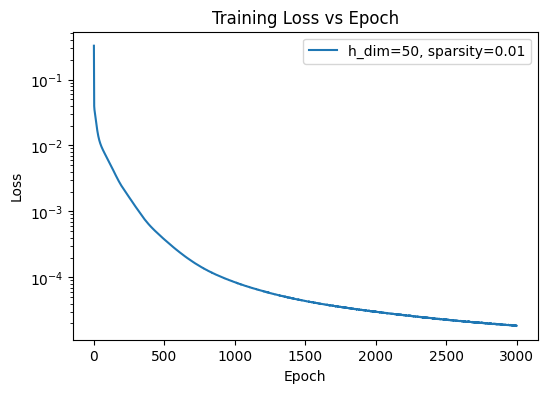

 Done: h_dim=50, sparsity_target=0.01, Final Loss=0.000018523


>>> Training SAE | h_dim=50, sparsity_target=0.04
Epoch 0/3000 - Loss: 0.344963569
Epoch 500/3000 - Loss: 0.000206655
Epoch 1000/3000 - Loss: 0.000038814
Epoch 1500/3000 - Loss: 0.000024973
Epoch 2000/3000 - Loss: 0.000019317
Epoch 2500/3000 - Loss: 0.000016236
 Done: h_dim=50, sparsity_target=0.04, Final Loss=0.000014383



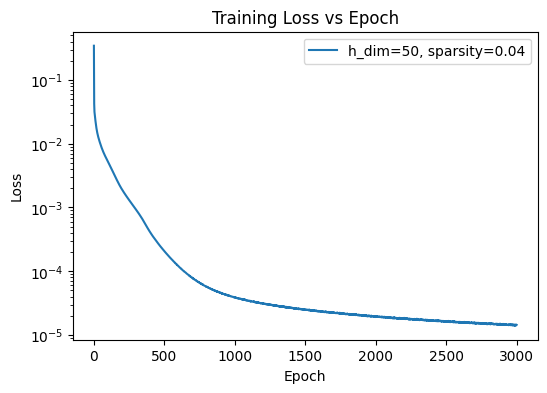

 Done: h_dim=50, sparsity_target=0.04, Final Loss=0.000014383


>>> Training SAE | h_dim=50, sparsity_target=0.08
Epoch 0/3000 - Loss: 0.433642378
Epoch 500/3000 - Loss: 0.000143177
Epoch 1000/3000 - Loss: 0.000035967
Epoch 1500/3000 - Loss: 0.000024473
Epoch 2000/3000 - Loss: 0.000019608
Epoch 2500/3000 - Loss: 0.000017726
 Done: h_dim=50, sparsity_target=0.08, Final Loss=0.000015607



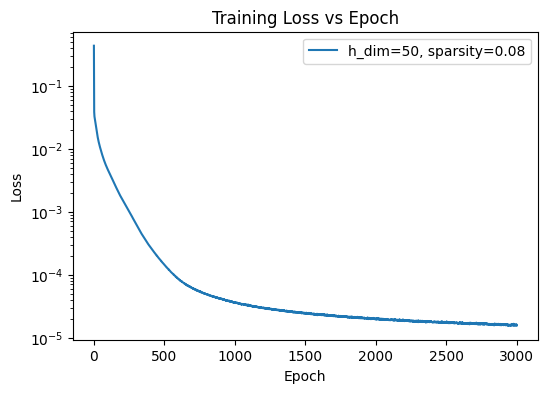

 Done: h_dim=50, sparsity_target=0.08, Final Loss=0.000015607


>>> Training SAE | h_dim=50, sparsity_target=0.12
Epoch 0/3000 - Loss: 0.235340350
Epoch 500/3000 - Loss: 0.000127043
Epoch 1000/3000 - Loss: 0.000042941
Epoch 1500/3000 - Loss: 0.000030995
Epoch 2000/3000 - Loss: 0.000025482
Epoch 2500/3000 - Loss: 0.000023093
 Done: h_dim=50, sparsity_target=0.12, Final Loss=0.000020589



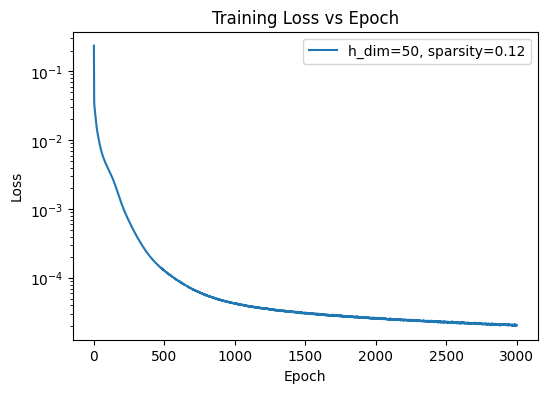

 Done: h_dim=50, sparsity_target=0.12, Final Loss=0.000020589


>>> Training SAE | h_dim=70, sparsity_target=0.01
Epoch 0/3000 - Loss: 0.461099363
Epoch 500/3000 - Loss: 0.000339147
Epoch 1000/3000 - Loss: 0.000068842
Epoch 1500/3000 - Loss: 0.000033603
Epoch 2000/3000 - Loss: 0.000021267
Epoch 2500/3000 - Loss: 0.000015753
 Done: h_dim=70, sparsity_target=0.01, Final Loss=0.000012735



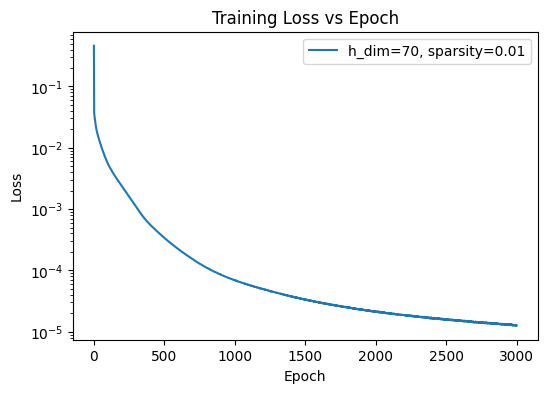

 Done: h_dim=70, sparsity_target=0.01, Final Loss=0.000012735


>>> Training SAE | h_dim=70, sparsity_target=0.04
Epoch 0/3000 - Loss: 0.250402255
Epoch 500/3000 - Loss: 0.000155967
Epoch 1000/3000 - Loss: 0.000033117
Epoch 1500/3000 - Loss: 0.000020973
Epoch 2000/3000 - Loss: 0.000015468
Epoch 2500/3000 - Loss: 0.000012656
 Done: h_dim=70, sparsity_target=0.04, Final Loss=0.000010892



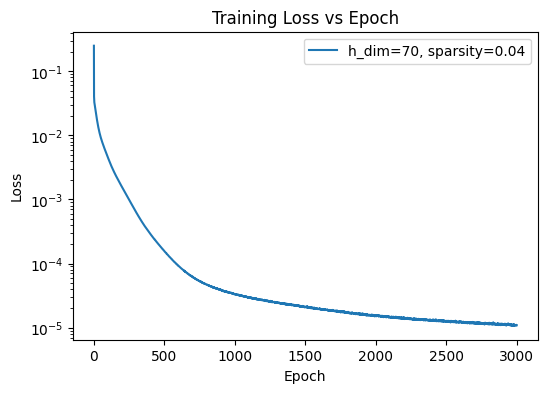

 Done: h_dim=70, sparsity_target=0.04, Final Loss=0.000010892


>>> Training SAE | h_dim=70, sparsity_target=0.08
Epoch 0/3000 - Loss: 0.304558213
Epoch 500/3000 - Loss: 0.000121093
Epoch 1000/3000 - Loss: 0.000033308
Epoch 1500/3000 - Loss: 0.000022406
Epoch 2000/3000 - Loss: 0.000017696
Epoch 2500/3000 - Loss: 0.000015706
 Done: h_dim=70, sparsity_target=0.08, Final Loss=0.000014112



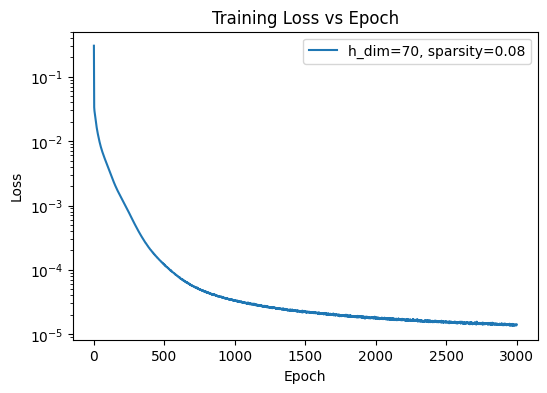

 Done: h_dim=70, sparsity_target=0.08, Final Loss=0.000014112


>>> Training SAE | h_dim=70, sparsity_target=0.12
Epoch 0/3000 - Loss: 0.464720371
Epoch 500/3000 - Loss: 0.000134013
Epoch 1000/3000 - Loss: 0.000042666
Epoch 1500/3000 - Loss: 0.000029606
Epoch 2000/3000 - Loss: 0.000023648
Epoch 2500/3000 - Loss: 0.000021674
 Done: h_dim=70, sparsity_target=0.12, Final Loss=0.000019519



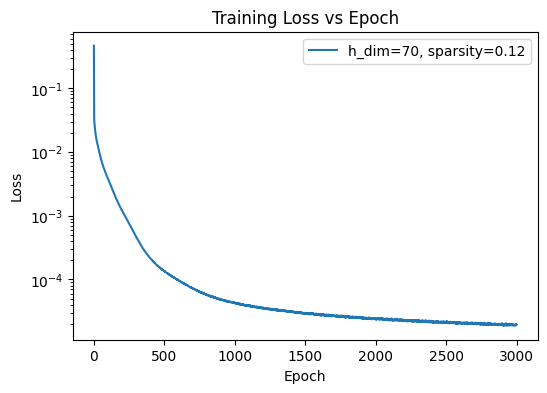

 Done: h_dim=70, sparsity_target=0.12, Final Loss=0.000019519


>>> Training SAE | h_dim=90, sparsity_target=0.01
Epoch 0/3000 - Loss: 0.319639851
Epoch 500/3000 - Loss: 0.000339519
Epoch 1000/3000 - Loss: 0.000064668
Epoch 1500/3000 - Loss: 0.000025465
Epoch 2000/3000 - Loss: 0.000015469
Epoch 2500/3000 - Loss: 0.000011811
 Done: h_dim=90, sparsity_target=0.01, Final Loss=0.000009808



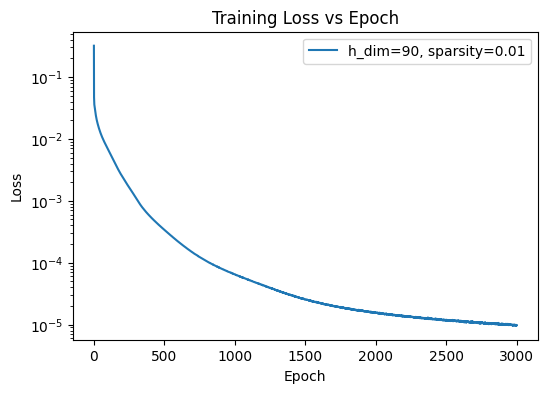

 Done: h_dim=90, sparsity_target=0.01, Final Loss=0.000009808


>>> Training SAE | h_dim=90, sparsity_target=0.04
Epoch 0/3000 - Loss: 0.281106700
Epoch 500/3000 - Loss: 0.000160977
Epoch 1000/3000 - Loss: 0.000031073
Epoch 1500/3000 - Loss: 0.000017258
Epoch 2000/3000 - Loss: 0.000013566
Epoch 2500/3000 - Loss: 0.000011538
 Done: h_dim=90, sparsity_target=0.04, Final Loss=0.000010225



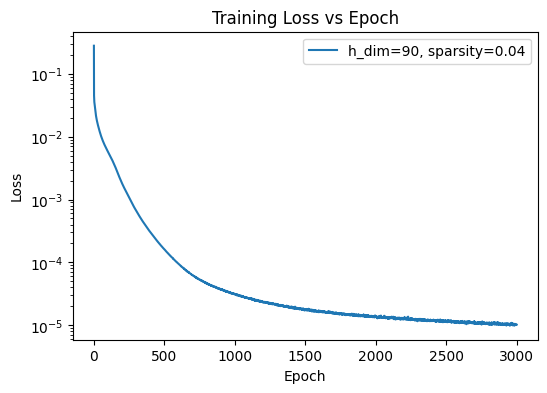

 Done: h_dim=90, sparsity_target=0.04, Final Loss=0.000010225


>>> Training SAE | h_dim=90, sparsity_target=0.08
Epoch 0/3000 - Loss: 0.209769109
Epoch 500/3000 - Loss: 0.000096084
Epoch 1000/3000 - Loss: 0.000028037
Epoch 1500/3000 - Loss: 0.000019663
Epoch 2000/3000 - Loss: 0.000016260
Epoch 2500/3000 - Loss: 0.000014132
 Done: h_dim=90, sparsity_target=0.08, Final Loss=0.000012810



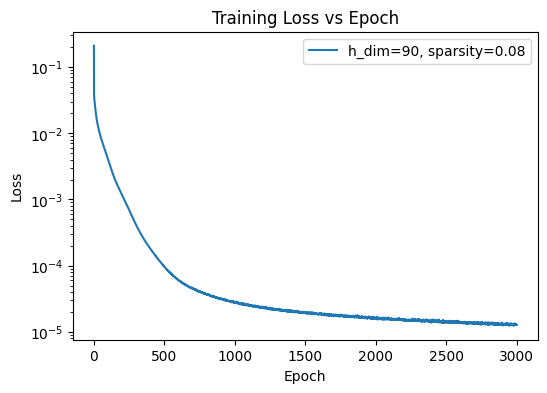

 Done: h_dim=90, sparsity_target=0.08, Final Loss=0.000012810


>>> Training SAE | h_dim=90, sparsity_target=0.12
Epoch 0/3000 - Loss: 0.509049791
Epoch 500/3000 - Loss: 0.000117410
Epoch 1000/3000 - Loss: 0.000039117
Epoch 1500/3000 - Loss: 0.000026974
Epoch 2000/3000 - Loss: 0.000023091
Epoch 2500/3000 - Loss: 0.000020980
 Done: h_dim=90, sparsity_target=0.12, Final Loss=0.000017674



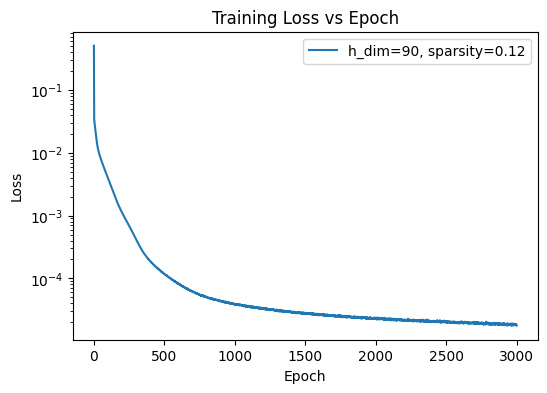

 Done: h_dim=90, sparsity_target=0.12, Final Loss=0.000017674


>>> Training SAE | h_dim=110, sparsity_target=0.01
Epoch 0/3000 - Loss: 0.135989706
Epoch 500/3000 - Loss: 0.000277865
Epoch 1000/3000 - Loss: 0.000046879
Epoch 1500/3000 - Loss: 0.000020761
Epoch 2000/3000 - Loss: 0.000013233
Epoch 2500/3000 - Loss: 0.000010005
 Done: h_dim=110, sparsity_target=0.01, Final Loss=0.000008262



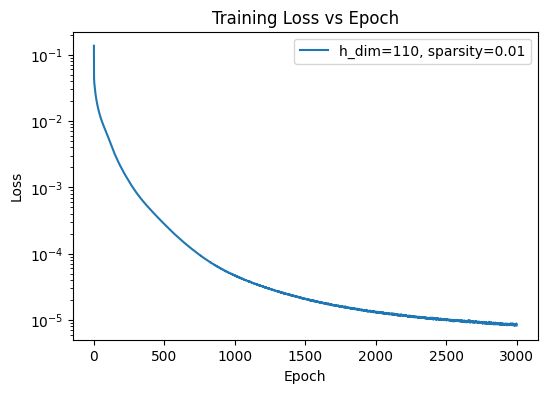

 Done: h_dim=110, sparsity_target=0.01, Final Loss=0.000008262


>>> Training SAE | h_dim=110, sparsity_target=0.04
Epoch 0/3000 - Loss: 0.353174217
Epoch 500/3000 - Loss: 0.000134723
Epoch 1000/3000 - Loss: 0.000026543
Epoch 1500/3000 - Loss: 0.000016063
Epoch 2000/3000 - Loss: 0.000012635
Epoch 2500/3000 - Loss: 0.000010338
 Done: h_dim=110, sparsity_target=0.04, Final Loss=0.000009364



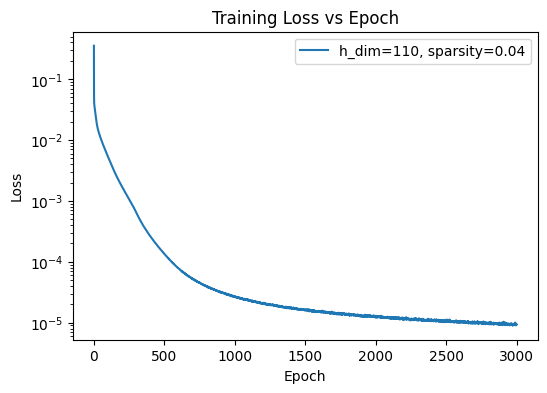

 Done: h_dim=110, sparsity_target=0.04, Final Loss=0.000009364


>>> Training SAE | h_dim=110, sparsity_target=0.08
Epoch 0/3000 - Loss: 0.165828795
Epoch 500/3000 - Loss: 0.000092172
Epoch 1000/3000 - Loss: 0.000029572
Epoch 1500/3000 - Loss: 0.000020064
Epoch 2000/3000 - Loss: 0.000016714
Epoch 2500/3000 - Loss: 0.000014472
 Done: h_dim=110, sparsity_target=0.08, Final Loss=0.000012975



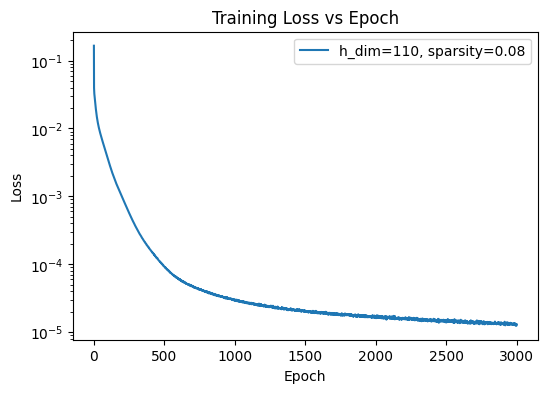

 Done: h_dim=110, sparsity_target=0.08, Final Loss=0.000012975


>>> Training SAE | h_dim=110, sparsity_target=0.12
Epoch 0/3000 - Loss: 0.185267345
Epoch 500/3000 - Loss: 0.000097245
Epoch 1000/3000 - Loss: 0.000037007
Epoch 1500/3000 - Loss: 0.000026895
Epoch 2000/3000 - Loss: 0.000022662
Epoch 2500/3000 - Loss: 0.000019741
 Done: h_dim=110, sparsity_target=0.12, Final Loss=0.000017800



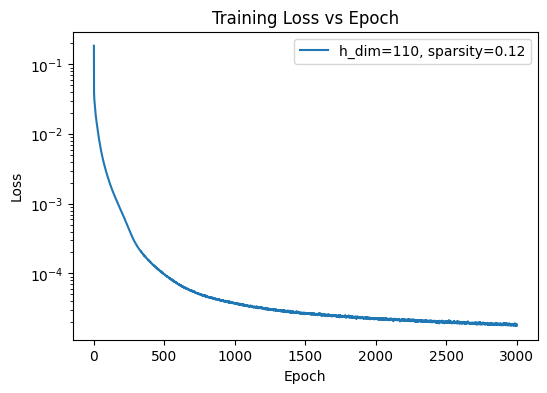

 Done: h_dim=110, sparsity_target=0.12, Final Loss=0.000017800


>>> Training SAE | h_dim=130, sparsity_target=0.01
Epoch 0/3000 - Loss: 0.285059152
Epoch 500/3000 - Loss: 0.000304573
Epoch 1000/3000 - Loss: 0.000052538
Epoch 1500/3000 - Loss: 0.000020323
Epoch 2000/3000 - Loss: 0.000012293
Epoch 2500/3000 - Loss: 0.000009325
 Done: h_dim=130, sparsity_target=0.01, Final Loss=0.000007890



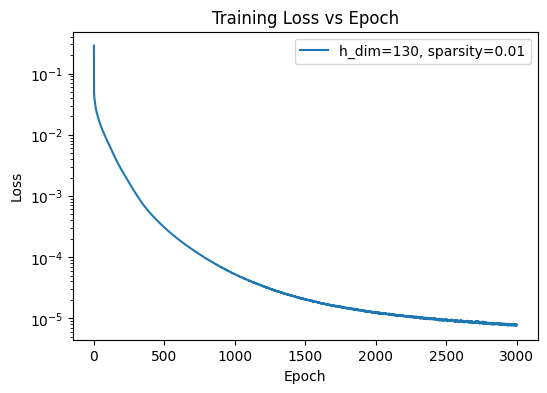

 Done: h_dim=130, sparsity_target=0.01, Final Loss=0.000007890


>>> Training SAE | h_dim=130, sparsity_target=0.04
Epoch 0/3000 - Loss: 0.148227874
Epoch 500/3000 - Loss: 0.000109110
Epoch 1000/3000 - Loss: 0.000027496
Epoch 1500/3000 - Loss: 0.000016604
Epoch 2000/3000 - Loss: 0.000013026
Epoch 2500/3000 - Loss: 0.000011187
 Done: h_dim=130, sparsity_target=0.04, Final Loss=0.000009447



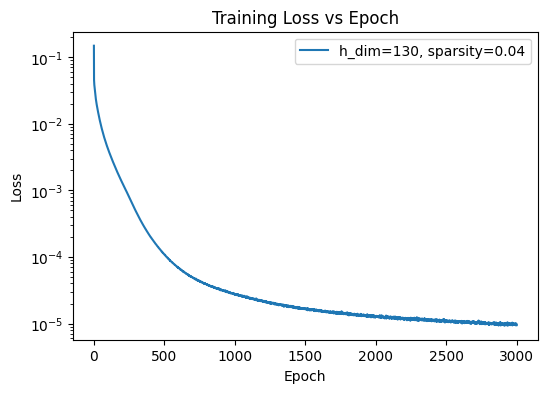

 Done: h_dim=130, sparsity_target=0.04, Final Loss=0.000009447


>>> Training SAE | h_dim=130, sparsity_target=0.08
Epoch 0/3000 - Loss: 0.115367442
Epoch 500/3000 - Loss: 0.000093076
Epoch 1000/3000 - Loss: 0.000031682
Epoch 1500/3000 - Loss: 0.000022810
Epoch 2000/3000 - Loss: 0.000017731
Epoch 2500/3000 - Loss: 0.000015489
 Done: h_dim=130, sparsity_target=0.08, Final Loss=0.000014221



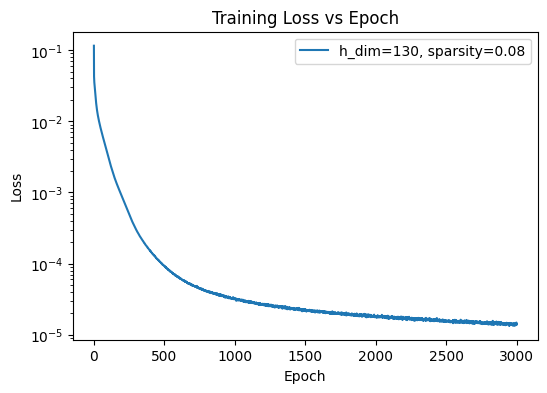

 Done: h_dim=130, sparsity_target=0.08, Final Loss=0.000014221


>>> Training SAE | h_dim=130, sparsity_target=0.12
Epoch 0/3000 - Loss: 0.200820351
Epoch 500/3000 - Loss: 0.000099491
Epoch 1000/3000 - Loss: 0.000037071
Epoch 1500/3000 - Loss: 0.000026752
Epoch 2000/3000 - Loss: 0.000021487
Epoch 2500/3000 - Loss: 0.000018485
 Done: h_dim=130, sparsity_target=0.12, Final Loss=0.000017115



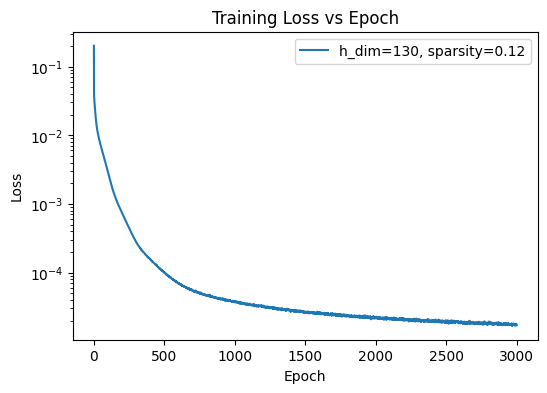

 Done: h_dim=130, sparsity_target=0.12, Final Loss=0.000017115


 Best SAE configuration: h_dim=130, sparsity_target=0.01, loss=0.000007890


In [10]:
# Train SAE for different latent dimensions
def train_sae(hidden_tensor, dataloader, h_dim, sparsity_target,
              sparsity_lambda, lr, n_epochs, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    in_dim = hidden_tensor.shape[1]
    sae = SparseAutoencoder(in_dim, h_dim, sparsity_lambda, sparsity_target).to(device)
    optimizer = torch.optim.Adam(sae.parameters(), lr=lr)
    epoch_losses = []

    print(f"\n>>> Training SAE | h_dim={h_dim}, sparsity_target={sparsity_target}")
    for epoch in range(n_epochs):
        total_loss = 0
        for batch_x, _ in dataloader:
            batch_x = batch_x.to(device)
            optimizer.zero_grad()
            encoded, decoded = sae(batch_x)
            loss = sae.loss_function(decoded, batch_x, encoded)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        epoch_losses.append(avg_loss)

        if epoch % 500 == 0:
            print(f"Epoch {epoch}/{n_epochs} - Loss: {avg_loss:.9f}")

    final_loss = epoch_losses[-1]
    print(f" Done: h_dim={h_dim}, sparsity_target={sparsity_target}, Final Loss={final_loss:.9f}\n")

    plt.figure(figsize=(6,4))
    plt.plot(range(n_epochs), epoch_losses, label=f"h_dim={h_dim}, sparsity={sparsity_target}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale('log')
    plt.title("Training Loss vs Epoch")
    plt.legend()
    plt.show()

    final_loss = total_loss / len(dataloader)
    print(f" Done: h_dim={h_dim}, sparsity_target={sparsity_target}, Final Loss={final_loss:.9f}\n")
    return final_loss, sae


# Experiment configurations

h_dims_list = [50,70,90,110,130]      # hidden layer sizes
sparsity_targets = [0.01,0.04,0.08,0.12]   # sparsity targets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

results = {}
best_loss = float('inf')
best_config = None
best_model = None

# Train models & track best configuration
for h_dim in h_dims_list:
    losses = []
    for sparsity_target in sparsity_targets:
        final_loss, sae_model = train_sae(hidden_tensor, dataloader, h_dim, sparsity_target,
                                          sparsity_lambda=2e-4, lr=1e-3, n_epochs=3000, device=device)
        losses.append(final_loss)

        # Track the best model
        if final_loss < best_loss:
            best_loss = final_loss
            best_config = (h_dim, sparsity_target)
            best_model = sae_model

    results[h_dim] = losses

print(f"\n Best SAE configuration: h_dim={best_config[0]}, sparsity_target={best_config[1]}, loss={best_loss:.9f}")

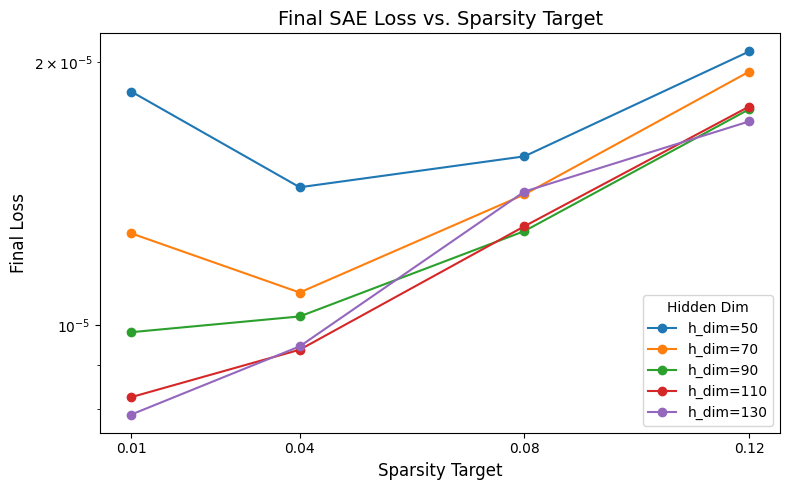

In [13]:
plt.figure(figsize=(8, 5))
for h_dim, losses in results.items():
    plt.plot(sparsity_targets, losses, marker='o', label=f'h_dim={h_dim}')
plt.xlabel('Sparsity Target', fontsize=12)
plt.ylabel('Final Loss', fontsize=12)
plt.title('Final SAE Loss vs. Sparsity Target', fontsize=14)
plt.legend(title='Hidden Dim')
plt.xticks(sparsity_targets)
plt.yscale('log')
plt.tight_layout()
plt.show()


In [17]:
sae = best_model
sae.eval()

with torch.no_grad():
    encoded_all, _ = sae(hidden_tensor.to(device))   # ALL data at once

encoded_all_np = encoded_all.cpu().numpy()
thresholds = np.mean(encoded_all_np, axis=0)

print("Thresholds calculated")


Thresholds calculated


In [18]:
n_points_dense = 20
x_vals_t = np.linspace(0, np.pi, n_points_dense)
y_vals_t = np.linspace(0, np.pi, n_points_dense)
t_vals_t = np.linspace(0, 1, n_points_dense)
X_grid_t, Y_grid, T_grid = np.meshgrid(x_vals_t, y_vals_t, t_vals_t, indexing="ij")
x_flat_t = X_grid_t.flatten()
y_flat_t = Y_grid.flatten()
t_flat_t = T_grid.flatten()

dense_test = torch.tensor(np.stack([x_flat_t, y_flat_t, t_flat_t], axis=1), dtype=torch.float32)

# -2 because last hidden layer (just before final output)
hook_handle = model.net[-2].register_forward_hook(get_activation('last_hidden'))

# Run the model
model.eval()
with torch.no_grad():
    _ = model(dense_test)

# Extract activations from the global 'activations' dictionary
last_hidden_dense = activations['last_hidden'].cpu().numpy()
print("Dense activations shape:", last_hidden_dense.shape)

# Remove hook (clean up)
hook_handle.remove()


Dense activations shape: (8000, 15)


Encoded dense activations shape: (8000, 130)


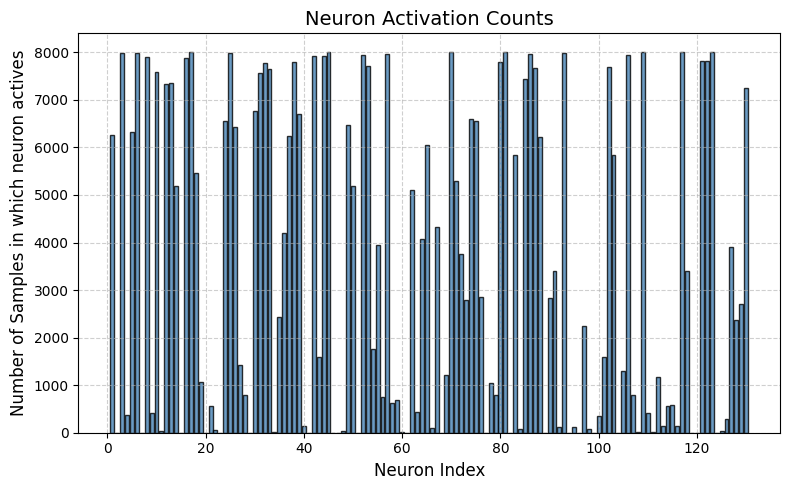

In [19]:
# Step 3: Pass dense activations through trained SAE encoder
dense_tensor_test = torch.tensor(last_hidden_dense, dtype=torch.float32).to(device)

sae.eval()
with torch.no_grad():
    encoded_dense, _ = sae(dense_tensor_test)

encoded_dense_np = encoded_dense.cpu().numpy()
print("Encoded dense activations shape:", encoded_dense_np.shape)

# Determine active neurons using thresholds

active_mask = encoded_dense_np >= thresholds  # shape: (N_dense, num_neurons)
active_ratio = active_mask.mean(axis=0)       # how often each neuron is active

# Count how many samples activated each neuron

neuron_activity_counts = np.sum(active_mask, axis=0)  # shape: (num_neurons,)
total_samples = active_mask.shape[0]


#  Plot histogram of neuron activity
plt.figure(figsize=(8, 5))
plt.bar(np.arange(len(neuron_activity_counts)) + 1,
        neuron_activity_counts,
        color='steelblue', edgecolor='black', alpha=0.8)

plt.xlabel("Neuron Index", fontsize=12)
plt.ylabel("Number of Samples in which neuron actives", fontsize=12)
plt.title("Neuron Activation Counts", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Now we want to check which sample input activates most of feature/neurosn in the best trained SAE

In [20]:
sample_activity_counts = np.sum(active_mask, axis=1)  # shape: (N_dense,)

# Sort samples by number of active neurons
top_k = 20  # or any number you want
top_indices = np.argsort(-sample_activity_counts)[:top_k]

print(f"\nTop {top_k} most neuron-active samples:")
for i, idx in enumerate(top_indices):
    print(f"{i+1}. Sample {idx}: activated {sample_activity_counts[idx]} neurons")



Top 20 most neuron-active samples:
1. Sample 1: activated 78 neurons
2. Sample 3: activated 77 neurons
3. Sample 0: activated 77 neurons
4. Sample 4: activated 76 neurons
5. Sample 2: activated 76 neurons
6. Sample 5: activated 76 neurons
7. Sample 403: activated 75 neurons
8. Sample 402: activated 74 neurons
9. Sample 401: activated 73 neurons
10. Sample 400: activated 72 neurons
11. Sample 6: activated 72 neurons
12. Sample 404: activated 72 neurons
13. Sample 405: activated 72 neurons
14. Sample 406: activated 71 neurons
15. Sample 7: activated 71 neurons
16. Sample 4723: activated 71 neurons
17. Sample 4387: activated 71 neurons
18. Sample 4385: activated 71 neurons
19. Sample 4744: activated 71 neurons
20. Sample 4745: activated 70 neurons
